In [1]:
import pandas as pd 
from sqlalchemy import create_engine
import matplotlib.pyplot as plt  
import numpy as np
from scipy import stats
import math
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
import datetime
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score
from scipy.stats import norm
import time
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sqlalchemy import create_engine


pd.set_option('display.max_columns', 500)

In [2]:

engine = create_engine('postgresql+psycopg2://postgres@localhost/market')
df = pd.read_sql_query('select * from "ticker"',con=engine).drop('id', axis=1).set_index(['coin', 'date', 'period'])
df.head()

high          low     close         open  \
coin     date       period                                                    
USDT_BTC 1502496000 86400   3767.505000  3591.565083  3767.505  3649.000000   
         1502582400 86400   4254.884025  3833.000000  4025.000  3865.000000   
         1502668800 86400   4245.000000  3965.000000  4186.000  4051.697404   
         1502755200 86400   4426.000000  3761.704612  4149.000  4310.928000   
         1502841600 86400   4395.555000  3926.000000  4381.000  4146.000000   

                                  volume  quote_volume  weightedAverage  
coin     date       period                                               
USDT_BTC 1502496000 86400   1.085429e+07   2944.275317      3686.572821  
         1502582400 86400   6.890607e+07  17104.434329      4028.550058  
         1502668800 86400   1.861486e+07   4534.267257      4105.373307  
         1502755200 86400   8.020934e+07  19596.059474      4093.136035  
         1502841600 86400   4.042729e+07   9680.759417      4176.044970

In [3]:
df_t = pd.read_sql_query('select * from "technical_indicator" ',con=engine).drop('id', axis=1)
df_t = df_t.loc[(df_t['indicator'] != 'EMA100') & (df_t['indicator'] != 'SMA100')].copy()
df_t = pd.pivot_table(df_t, index=['coin', 'date', 'period'], columns='indicator', values='value').copy()

In [4]:
all_df = df.join(df_t).reset_index()

In [5]:
period = 86400
coin = 'USDT_XMR'
big_df = all_df.loc[(all_df['coin'] == coin) & (all_df['period'] == period)].dropna()
big_df.head()

,coin,date,period,high,low,close,open,volume,quote_volume,weightedAverage,ADX,ATR,BBLower,BBMiddle,BBUpper,EMA12,EMA26,EMA50,EMA9,HISTOGRAM,MACD,MOMENTUM,OBV,RSI14,SIGNAL,SMA12,SMA26,SMA50,SMA9,TREND_COIN,WILLR
2449,USDT_XMR,1506729600,86400,97.000000,94.411000,96.049100,94.799705,428634.044552,4466.878409,95.958297,28.787036,10.814724,90.927639,97.084880,103.242121,93.944900,101.833881,97.249847,94.267467,-1.154828,-0.313188,6.658900,4.013750e+07,49.264243,0.841639,93.944900,101.833881,97.249847,94.267467,22238.0,-42.168946
2450,USDT_XMR,1506816000,86400,96.493202,91.817000,93.384077,96.049100,345247.740894,3681.064825,93.790182,28.319542,10.376258,90.721975,97.021695,103.321415,93.569332,100.869373,98.133510,94.921253,-1.105264,-0.539941,-0.709223,3.979225e+07,47.398964,0.565323,93.569332,100.869373,98.133510,94.921253,22209.0,-54.960035
2451,USDT_XMR,1506902400,86400,94.187600,91.000000,91.766000,93.996859,470121.991670,5097.154041,92.232251,27.967223,9.862783,90.477182,94.874895,99.272608,93.273165,99.668066,99.039144,94.895331,-1.124675,-0.840521,-1.934000,3.932213e+07,46.253865,0.284154,93.273165,99.668066,99.039144,94.895331,22122.0,-62.726182
2452,USDT_XMR,1506988800,86400,94.904300,87.000000,93.266810,91.458501,700484.979073,7761.735857,90.248495,28.034312,9.722891,90.920056,93.893197,96.866339,93.902007,98.528328,99.931570,95.326065,-0.984697,-0.946716,-9.233190,4.002262e+07,47.520283,0.037980,93.902007,98.528328,99.931570,95.326065,22148.0,-55.522868
2453,USDT_XMR,1507075200,86400,94.364055,88.048413,89.960183,93.266809,443729.627262,4858.743105,91.326011,28.096610,9.479516,88.863981,92.885234,96.906488,94.107023,97.505573,100.756536,94.866830,-1.056709,-1.282906,-8.215117,3.957889e+07,45.004189,-0.226197,94.107023,97.505573,100.756536,94.866830,22224.0,-71.393409


In [6]:
period = 14400
filter_df = all_df.loc[(all_df['coin'] == coin) & (all_df['period'] == period)].dropna()
filter_df.head()

,coin,date,period,high,low,close,open,volume,quote_volume,weightedAverage,ADX,ATR,BBLower,BBMiddle,BBUpper,EMA12,EMA26,EMA50,EMA9,HISTOGRAM,MACD,MOMENTUM,OBV,RSI14,SIGNAL,SMA12,SMA26,SMA50,SMA9,TREND_COIN,WILLR
17695,USDT_XMR,1503187200,14400,56.120000,53.662600,54.255376,55.715446,115190.231504,2106.518482,54.682754,28.688971,2.555723,49.253532,53.612162,57.970792,50.810076,49.368268,48.865036,51.697088,0.769382,1.538617,3.950076,1.002546e+06,62.167120,0.769234,50.810076,49.368268,48.865036,51.697088,3617.0,-31.676300
17696,USDT_XMR,1503201600,14400,54.581455,52.666450,53.911250,54.255376,143511.266250,2697.410858,53.203340,28.660208,2.509958,51.538095,54.344561,57.151028,51.265905,49.568243,48.936073,52.240195,0.664265,1.599565,2.486850,8.590346e+05,60.893131,0.935301,51.265905,49.568243,48.936073,52.240195,3619.0,-34.244404
17697,USDT_XMR,1503216000,14400,53.828514,51.900000,52.442672,53.828514,74039.500007,1399.584853,52.901044,28.140310,2.474336,51.914947,54.433096,56.951244,51.592018,49.729315,48.957461,52.904937,0.461309,1.511937,2.193420,7.849951e+05,55.651726,1.050628,51.592018,49.729315,48.957461,52.904937,3628.0,-45.203938
17698,USDT_XMR,1503230400,14400,56.000000,52.442672,55.441105,52.813160,194388.678460,3598.067040,54.025863,28.449650,2.551692,52.026047,54.336502,56.646956,52.255735,50.045815,49.082265,53.475582,0.491692,1.665243,3.441105,9.793838e+05,62.709391,1.173551,52.255735,50.045815,49.082265,53.475582,3637.0,-22.827573
17699,USDT_XMR,1503244800,14400,56.460000,54.390345,55.643662,55.441105,207573.985114,3733.035537,55.604610,28.887269,2.517261,52.023162,54.338813,56.654464,52.807433,50.365449,49.272339,53.944389,0.487188,1.782536,-0.280414,1.186958e+06,63.136188,1.295348,52.807433,50.365449,49.272339,53.944389,3634.0,-21.315956


# Setting Up Trend In 24h Screen

In [7]:
closes = big_df[['date', 'close']]
win = 30
seq = np.arange(0, win)
di = []
for i in range(win, len(closes)):
    v_closes = closes.iloc[i-win:i]
    base_date = v_closes.iloc[-1:][['date']].values[0][0]
    slope, intercept, r_value, p_value, std_err = stats.linregress(seq, v_closes['close'].values)
    di.append({
        'base_date': base_date,
        'slope': slope
    })
for index, row in filter_df.iterrows():
    date = row['date']
    slopes = [d for d in di if d['base_date'] <= date]
    if slopes:
        filter_df.ix[index, 'slope'] = sorted(slopes, key=lambda x: x['base_date'], reverse=True)[0]['slope']

/Users/macbookpro/anaconda2/envs/cryptocurrency-analysis/lib/python3.6/site-packages/ipykernel/__main__.py:17: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


# Setting Up Trend In 6h Screen

In [8]:
closes = filter_df[['date', 'close']]
win = 30
seq = np.arange(0, win)
di = []
for i in range(win, len(closes)):
    v_closes = closes.iloc[i-win:i]
    base_date = v_closes.iloc[-1:][['date']].values[0][0]
    slope, intercept, r_value, p_value, std_err = stats.linregress(seq, v_closes['close'].values)
    di.append({
        'base_date': base_date,
        'slope': slope
    })
for index, row in filter_df.iterrows():
    date = row['date']
    slopes = [d for d in di if d['base_date'] <= date]
    if slopes:
        filter_df.ix[index, 'slope_short'] = sorted(slopes, key=lambda x: x['base_date'], reverse=True)[0]['slope']

/Users/macbookpro/anaconda2/envs/cryptocurrency-analysis/lib/python3.6/site-packages/ipykernel/__main__.py:17: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


## Primary indicators:
    - 'EMA12', 'EMA26', 'EMA50', 'EMA9'
    - 'SMA12', 'SMA26', 'SMA50', 'SMA9'
    - 'MOMENTUM'
    - 'slope', 'slope_short'
    - 'close' comparisons
    - 'TREND_COIN'
    
    - 'ADX'
    - 'ATR'
    - 'BBLower', 'BBMiddle', 'BBUpper'
    - 'HISTOGRAM', 'MACD','SIGNAL'
    - 'OBV'
    - 'RSI14', 
    - 'WILLR' 

## Calculating Relative Indicators 

In [9]:
filter_df['BBand_height'] = filter_df['BBUpper']/filter_df['BBLower']
filter_df['BBand_lower_height'] = filter_df['BBLower']/filter_df['close']
filter_df['BBand_upper_height'] = filter_df['BBUpper']/filter_df['close']

filter_df['EMA_height12'] = filter_df['EMA12']/filter_df['close']
filter_df['EMA_height26'] = filter_df['EMA26']/filter_df['close']


filter_df['SMA_height12'] = filter_df['SMA12']/filter_df['close']
filter_df['SMA_height26'] = filter_df['SMA26']/filter_df['close']

filter_df['close_open'] = filter_df['open']/filter_df['close']
filter_df['close_low'] = filter_df['low']/filter_df['close']
filter_df['close_high'] = filter_df['high']/filter_df['close']


filter_df['log_trend'] = np.log(filter_df['TREND_COIN']/filter_df['TREND_COIN'].shift(1))

filter_df['log_return'] = np.log(filter_df['close']/filter_df['close'].shift(1))
filter_df['log_return_2'] = np.log(filter_df.close/filter_df.close.shift(2))
filter_df['log_return_3'] = np.log(filter_df.close/filter_df.close.shift(3))
filter_df['log_return_4'] = np.log(filter_df.close/filter_df.close.shift(4))

## Calculating Statiscials Indicators
    - Mean
    - Variance
    - Stdev

In [10]:
filter_df['coin'].unique()
window = 2
look_back_size = math.floor((3600*24*window)/period)
for index, row in filter_df.iterrows():
    base_date = row['date']
    window_df = filter_df.loc[filter_df['date'] <= base_date]
    if window_df.empty or len(window_df) < look_back_size:
        continue
    log_returns = window_df[-look_back_size:]['log_return']
    mean = log_returns.mean()
    var = log_returns.var()
    stdev = log_returns.std()
    filter_df.ix[index, 'mean_return'] = mean
    filter_df.ix[index, 'variance'] = var
    filter_df.ix[index, 'stdev'] = stdev
    
filter_df.head()

/Users/macbookpro/anaconda2/envs/cryptocurrency-analysis/lib/python3.6/site-packages/ipykernel/__main__.py:13: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/Users/macbookpro/anaconda2/envs/cryptocurrency-analysis/lib/python3.6/site-packages/ipykernel/__main__.py:14: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/Users/macbookpro/anaconda2/envs/cryptocurrency-analysis/lib/python3.6/site-packages/ipykernel/__main__.py:15: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-

,coin,date,period,high,low,close,open,volume,quote_volume,weightedAverage,ADX,ATR,BBLower,BBMiddle,BBUpper,EMA12,EMA26,EMA50,EMA9,HISTOGRAM,MACD,MOMENTUM,OBV,RSI14,SIGNAL,SMA12,SMA26,SMA50,SMA9,TREND_COIN,WILLR,slope,slope_short,BBand_height,BBand_lower_height,BBand_upper_height,EMA_height12,EMA_height26,SMA_height12,SMA_height26,close_open,close_low,close_high,log_trend,log_return,log_return_2,log_return_3,log_return_4,mean_return,variance,stdev
17695,USDT_XMR,1503187200,14400,56.120000,53.662600,54.255376,55.715446,115190.231504,2106.518482,54.682754,28.688971,2.555723,49.253532,53.612162,57.970792,50.810076,49.368268,48.865036,51.697088,0.769382,1.538617,3.950076,1.002546e+06,62.167120,0.769234,50.810076,49.368268,48.865036,51.697088,3617.0,-31.676300,NaN,NaN,1.176988,0.907809,1.068480,0.936498,0.909924,0.936498,0.909924,1.026911,0.989074,1.034368,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17696,USDT_XMR,1503201600,14400,54.581455,52.666450,53.911250,54.255376,143511.266250,2697.410858,53.203340,28.660208,2.509958,51.538095,54.344561,57.151028,51.265905,49.568243,48.936073,52.240195,0.664265,1.599565,2.486850,8.590346e+05,60.893131,0.935301,51.265905,49.568243,48.936073,52.240195,3619.0,-34.244404,NaN,NaN,1.108908,0.955980,1.060095,0.950931,0.919442,0.950931,0.919442,1.006383,0.976910,1.012432,0.000553,-0.006363,NaN,NaN,NaN,NaN,NaN,NaN
17697,USDT_XMR,1503216000,14400,53.828514,51.900000,52.442672,53.828514,74039.500007,1399.584853,52.901044,28.140310,2.474336,51.914947,54.433096,56.951244,51.592018,49.729315,48.957461,52.904937,0.461309,1.511937,2.193420,7.849951e+05,55.651726,1.050628,51.592018,49.729315,48.957461,52.904937,3628.0,-45.203938,NaN,NaN,1.097011,0.989937,1.085971,0.983779,0.948261,0.983779,0.948261,1.026426,0.989652,1.026426,0.002484,-0.027619,-0.033981,NaN,NaN,NaN,NaN,NaN
17698,USDT_XMR,1503230400,14400,56.000000,52.442672,55.441105,52.813160,194388.678460,3598.067040,54.025863,28.449650,2.551692,52.026047,54.336502,56.646956,52.255735,50.045815,49.082265,53.475582,0.491692,1.665243,3.441105,9.793838e+05,62.709391,1.173551,52.255735,50.045815,49.082265,53.475582,3637.0,-22.827573,NaN,NaN,1.088819,0.938402,1.021750,0.942545,0.902684,0.942545,0.902684,0.952599,0.945917,1.010081,0.002478,0.055601,0.027982,0.021619,NaN,NaN,NaN,NaN
17699,USDT_XMR,1503244800,14400,56.460000,54.390345,55.643662,55.441105,207573.985114,3733.035537,55.604610,28.887269,2.517261,52.023162,54.338813,56.654464,52.807433,50.365449,49.272339,53.944389,0.487188,1.782536,-0.280414,1.186958e+06,63.136188,1.295348,52.807433,50.365449,49.272339,53.944389,3634.0,-21.315956,NaN,NaN,1.089024,0.934934,1.018166,0.949029,0.905143,0.949029,0.905143,0.996360,0.977476,1.014671,-0.000825,0.003647,0.059248,0.031629,0.025266,NaN,NaN,NaN


In [11]:
lags = [1]
indicators = [
    'ADX', 'ATR',
    'HISTOGRAM', 'MACD', 'MOMENTUM', 'RSI14', 'SIGNAL',
    'BBand_lower_height', 'BBand_upper_height', 
    'slope_short',
    'EMA_height12', 'EMA_height26', 'SMA_height12', 'SMA_height26',
   'log_trend'
             ]
for ind in indicators:
    for i in lags:
        filter_df[ind + '_lag' + str(i)] = filter_df[ind].shift(i)

In [12]:
filter_df.head()

features_df = filter_df.dropna().copy()

features_df['target_log_return_1'] = np.log(features_df.close.shift(-1)/features_df.close)
features_df['target_log_return_2'] = np.log(features_df.close.shift(-2)/features_df.close)
features_df['target_log_return_3'] = np.log(features_df.close.shift(-3)/features_df.close)
features_df['target_log_return_4'] = np.log(features_df.close.shift(-4)/features_df.close)
features_df['target_log_return_5'] = np.log(features_df.close.shift(-5)/features_df.close)
features_df['target_log_return_6'] = np.log(features_df.close.shift(-6)/features_df.close)

In [13]:
def run_model(X_sample, y_sample, target_value, models=models):
    scaler = MinMaxScaler().fit(X_sample)
    X_sample = scaler.transform(X_sample)
    # Split Train, Test
    X_train, X_test = X_sample[:math.floor(len(X_sample) * 0.75)], X_sample[math.ceil(len(X_sample) * 0.75):]
    y_train, y_test = y_sample.iloc[:math.floor(len(y_sample) * 0.75)], y_sample.iloc[math.ceil(len(y_sample) * 0.75):]

    # Rebalance Samples

    oversampler = SMOTE(random_state=42)
    X_train, y_train = oversampler.fit_sample(X_train, y_train.target_sign)
    # (Re) define Models
    precisions = []

    # Run Models

    for k, v in models.items():
        v.fit(X_train, y_train)
        predicted_proba = v.predict_proba(X_test)
        predicted = (predicted_proba[:, 1] >= threshold).astype('int')
        precision = precision_score(y_test, predicted)
        train_acc = accuracy_score(y_test, predicted)
        precisions.append({
            'Model': k,
            'Precision': precision,
            'Accuracy': train_acc,
            'Trades': np.sum(predicted),
            'Real Profits': np.sum(y_test)[0],
            'Model_model': v,
            'Target': target_value
        })

    return precisions
    

## Setting Up Target Future Values 

In [14]:
target_values = [0, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03]
results_target = []
threshold = 0.80
n_samples = 3
p = 1/n_samples
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Extra Tree': ExtraTreesClassifier(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Gradient Boost': GradientBoostingClassifier(random_state=42)
}

for target_value in target_values:
    # Setting up target values
    mask = (
       ((features_df['target_log_return_1'] >= target_value)
        | (features_df['target_log_return_2'] >= target_value) 
        | (features_df['target_log_return_3'] >= target_value) 
        | (features_df['target_log_return_4'] >= target_value)
        | (features_df['target_log_return_5'] >= target_value)
        | (features_df['target_log_return_6'] >= target_value))
           )
    features_df.loc[mask, 'target_sign'] = 1
    features_df.loc[~mask, 'target_sign'] = 0
    
    drop_columns = ['coin', 'date', 'period', 
                'high', 'low', 'open', 'close', 'volume', 'quote_volume',
                'weightedAverage',
                'BBUpper', 'BBLower', 'BBMiddle',
                'EMA9', 'EMA12', 'EMA26', 'EMA50',
                'SMA9', 'SMA12', 'SMA26', 'SMA50',
                'target_log_return_1', 'target_log_return_2', 'target_log_return_3',
                'target_log_return_4', 'target_log_return_5', 'target_log_return_6',
              'mean_return', 'variance', 'stdev'
               ]

    # Preparing dataframe
    clean_df = features_df.drop(drop_columns, axis=1).copy()
    # Defining Features (X) and Target Variable (y)
    
    
    X = clean_df.drop(['target_sign'], axis =1)
    y = clean_df[['target_sign']]

    p_sample = []
    end_sample = 0
    base_sample = 0
    for p_i in range(1, n_samples+1):
        end_sample = p_i * p * len(X)
        # Slicing Folders
        X_sample = X[base_sample:math.floor(end_sample)]
        y_sample = y.iloc[base_sample:math.floor(end_sample)]
        base_sample = math.floor(end_sample)
        p_sample.append(run_model(X_sample, y_sample, threshold, names_models, models))

    # Getting Average From Each Model Performance
    avg_models = []
    for nm in names_models:
        avg_precision = np.mean([p['Precision'] for ps in p_sample for p in ps if p['Model'] == nm])
        avg_models.append({
            'Model': nm,
            'Precision': avg_precision,
            'Target': target_value

        })
    for r in avg_models:
        results_target.append(r)
    #pd.DataFrame.from_records(precisions).to_csv(coin + '_modelresult.csv')

In [15]:
models_results_df = pd.DataFrame.from_records(results_target)

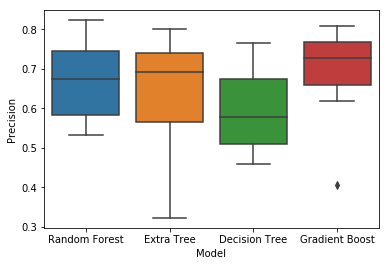

In [16]:
import seaborn as sns
ax = sns.boxplot(x="Model", y="Precision", data=models_results_df)
# g = sns.catplot(x="Model", y="Precision", col="Target", data=models_results_df, kind="box", height=4, aspect=.7)
plt.show()

In [17]:
quality_models = models_results_df.loc[models_results_df['Precision'] > 0.5].copy()
quality_models['Mult'] = quality_models['Precision'] * quality_models['Target']

,Model,Precision,Target,Mult
24,Random Forest,0.544143,0.030,0.016324
23,Gradient Boost,0.617871,0.025,0.015447
19,Gradient Boost,0.753592,0.020,0.015072
21,Extra Tree,0.570707,0.025,0.014268
16,Random Forest,0.673472,0.020,0.013469
20,Random Forest,0.531031,0.025,0.013276
22,Decision Tree,0.510081,0.025,0.012752
17,Extra Tree,0.559879,0.020,0.011198
15,Gradient Boost,0.700297,0.015,0.010504
13,Extra Tree,0.691688,0.015,0.010375


In [18]:
features_df.columns

Index(['coin', 'date', 'period', 'high', 'low', 'close', 'open', 'volume',
       'quote_volume', 'weightedAverage', 'ADX', 'ATR', 'BBLower', 'BBMiddle',
       'BBUpper', 'EMA12', 'EMA26', 'EMA50', 'EMA9', 'HISTOGRAM', 'MACD',
       'MOMENTUM', 'OBV', 'RSI14', 'SIGNAL', 'SMA12', 'SMA26', 'SMA50', 'SMA9',
       'TREND_COIN', 'WILLR', 'slope', 'slope_short', 'BBand_height',
       'BBand_lower_height', 'BBand_upper_height', 'EMA_height12',
       'EMA_height26', 'SMA_height12', 'SMA_height26', 'close_open',
       'close_low', 'close_high', 'log_trend', 'log_return', 'log_return_2',
       'log_return_3', 'log_return_4', 'mean_return', 'variance', 'stdev',
       'ADX_lag1', 'ATR_lag1', 'HISTOGRAM_lag1', 'MACD_lag1', 'MOMENTUM_lag1',
       'RSI14_lag1', 'SIGNAL_lag1', 'BBand_lower_height_lag1',
       'BBand_upper_height_lag1', 'slope_short_lag1', 'EMA_height12_lag1',
       'EMA_height26_lag1', 'SMA_height12_lag1', 'SMA_height26_lag1',
       'log_trend_lag1', 'target_log_return_1',

In [28]:
targets = ['target_log_return_1', 'target_log_return_2', 'target_log_return_3',
                'target_log_return_4', 'target_log_return_5', 'target_log_return_6',]
risk_free = ((1 + 0.065) ** (1/252) - 1)
simulations = []

for index, row in quality_models.iterrows():
    TP = row['Target']
    P = row['Precision']
    mask = (
       ((features_df['target_log_return_1'] >= TP)
        | (features_df['target_log_return_2'] >= TP) 
        | (features_df['target_log_return_3'] >= TP) 
        | (features_df['target_log_return_4'] >= TP)
        | (features_df['target_log_return_5'] >= TP)
        | (features_df['target_log_return_6'] >= TP))
           )
    features_df.loc[mask, 'target_sign'] = 1
    features_df.loc[~mask, 'target_sign'] = 0
    
    drop_columns = ['coin', 'date', 'period', 
                'high', 'low', 'open', 'close', 'volume', 'quote_volume',
                'weightedAverage',
                'BBUpper', 'BBLower', 'BBMiddle',
                'EMA9', 'EMA12', 'EMA26', 'EMA50',
                'SMA9', 'SMA12', 'SMA26', 'SMA50',
              'mean_return', 'variance', 'stdev'
               ]

    # Preparing dataframe
    clean_df = features_df.drop(drop_columns, axis=1).copy()
    returns = []
    for t in targets:
        returns.append(clean_df.loc[clean_df['target_sign'] == 0][t].values)

    flat_missed_list = [item for sublist in returns for item in sublist if not math.isnan(item)]

    returns = []
    for t in targets:
        returns.append(clean_df.loc[clean_df['target_sign'] == 1][t].values)

    flat_list = [item for sublist in returns for item in sublist if not math.isnan(item)]

    ps = 0.05
    while ps < 1:
        SL = np.percentile(flat_missed_list, ps*100)
        if SL < -3 * TP or SL > -0.01 :
            ps += 0.05
            continue
        P_stop_loss_right = len([f for f in flat_list if f <= SL])/len(flat_list)
        Mean_return_wrong = np.percentile(flat_missed_list, 15)
        ER = P * (1 - P_stop_loss_right) * TP + P * P_stop_loss_right * SL + (1 - P) * (1 - ps) * Mean_return_wrong  + (1 - P) * ps * SL
        simulations.append({
            'ER': ER,
            'Probability Stop Loss Miss': ps,
            'Probability Stop Loss Right': P_stop_loss_right,
            'Stop Loss': SL,
            'Multiple': ER/risk_free,
            'Model': row['Model'],
            'Precision': row['Precision'],
            'Take_profit': TP
        })
        ps += 0.05
    

In [29]:
col_order = ['Model', 'Take_profit', 'Stop Loss', 'Precision', 'Probability Stop Loss Miss', 'Probability Stop Loss Right',
            'ER', 'Multiple']
pd.DataFrame.from_records(simulations).sort_values(['Multiple', 'Precision'], ascending=False)[col_order]#.iloc[0]

,Model,Take_profit,Stop Loss,Precision,Probability Stop Loss Miss,Probability Stop Loss Right,ER,Multiple
95,Gradient Boost,0.020,-0.011217,0.753592,0.65,0.137573,0.003793,15.174252
94,Gradient Boost,0.020,-0.014981,0.753592,0.60,0.117425,0.002623,10.493512
93,Gradient Boost,0.020,-0.018581,0.753592,0.55,0.100897,0.001589,6.358197
92,Gradient Boost,0.020,-0.022988,0.753592,0.50,0.084055,0.000593,2.373310
65,Random Forest,0.020,-0.011217,0.673472,0.65,0.137573,-0.000081,-0.324126
91,Gradient Boost,0.020,-0.027512,0.753592,0.45,0.071305,-0.000348,-1.390705
135,Gradient Boost,0.025,-0.012299,0.617871,0.60,0.115038,-0.000708,-2.833035
90,Gradient Boost,0.020,-0.032418,0.753592,0.40,0.058870,-0.001157,-4.628959
55,Gradient Boost,0.015,-0.011104,0.700297,0.70,0.155052,-0.001534,-6.138470
64,Random Forest,0.020,-0.014981,0.673472,0.60,0.117425,-0.001692,-6.769989
